# **Facial Expression Recognition Using VGG16**

**Import Libraries**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.optimizers import Adam, SGD, RMSprop
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle                      
import cv2                                 
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, BatchNormalization, Dropout, Dense


**Load Dataset**

In [4]:
class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

# This size needed for EfficientNetB0
IMAGE_SIZE = (224, 224)

def load_data():
    datasets = ['./images/train/']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            count = 0
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
#                 image = cv2.imread(img_path)
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
                # Taking 1k images from of each type
                # bcause Notebook getting out of memory error
                count = count + 1
                if count == 1000:
                    break
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))
        
    return output

(images, labels) = load_data()[0]


Loading ./images/train/


 31%|███       | 999/3205 [00:00<00:00, 4012.42it/s]


**Preprocess Data**

In [5]:
# # Memory taken by array
print((images.nbytes/1024)/1024)

permutation  = np.random.permutation(len(images))

shuffled_images = images[permutation]
shuffled_labels = labels[permutation]

from sklearn.model_selection import train_test_split

train_images, test_images, train_labels, test_labels = train_test_split(shuffled_images, shuffled_labels, test_size=0.1)
train_images = train_images / 255.0 
test_images = test_images / 255.0

# # Memory taken by array
# (images.nbytes/1024)/1024


3695.671875


**Display Random Image**

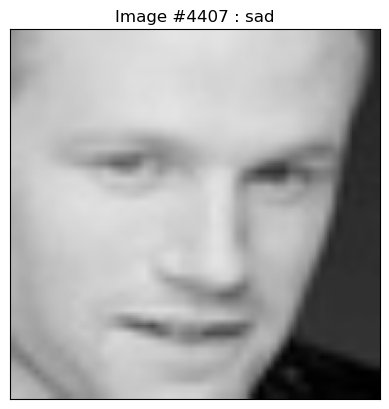

In [6]:
def display_random_image(class_names, images, labels):   
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()
    
display_random_image(class_names, train_images, train_labels)


**Fine-Tune VGG16 Model** 

We will tune only top layer

In [7]:
inputs = Input(shape=(224, 224, 3))
base_model = VGG16(
    weights='imagenet', 
    input_tensor=inputs,
    include_top=False
    ) 

base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = BatchNormalization()(x)
# x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(16, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(7, activation='softmax')(x)

model = Model(inputs, outputs)

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary(show_trainable=True)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer (InputLayer)    │ (None, 224, 224, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_conv1 (Conv2D)       │ (None, 224, 224, 64)  │      1,792 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_conv2 (Conv2D)       │ (None, 224, 224, 64)  │     36,928 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_pool (MaxPooling2D)  │ (None, 112, 112, 64)  │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_conv1 (Conv2D)       │ (None, 112, 112, 128) │     73,856 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_conv2 (Conv2D)       │ (None, 112, 112, 128) │    147,584 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_pool (MaxPooling2D)  │ (None, 56, 56, 128)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv1 (Conv2D)       │ (None, 56, 56, 256)   │    295,168 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv2 (Conv2D)       │ (None, 56, 56, 256)   │    590,080 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv3 (Conv2D)       │ (None, 56, 56, 256)   │    590,080 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_pool (MaxPooling2D)  │ (None, 28, 28, 256)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv1 (Conv2D)       │ (None, 28, 28, 512)   │  1,180,160 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv2 (Conv2D)       │ (None, 28, 28, 512)   │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv3 (Conv2D)       │ (None, 28, 28, 512)   │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_pool (MaxPooling2D)  │ (None, 14, 14, 512)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv1 (Conv2D)       │ (None, 14, 14, 512)   │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv2 (Conv2D)       │ (None, 14, 14, 512)   │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv3 (Conv2D)       │ (None, 14, 14, 512)   │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_pool (MaxPooling2D)  │ (None, 7, 7, 512)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 512)           │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ batch_normalization         │ (None, 512)           │      2,048 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 512)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 16)            │      8,208 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_1 (Dropout)         │ (None, 16)            │          0 │   - 

 Total params: 14,725,063 (56.17 MB)

 Trainable params: 9,351 (36.53 KB)

 Non-trainable params: 14,715,712 (56.14 MB)

**Train Model**

In [8]:
history = model.fit(train_images, train_labels, epochs=50, validation_split = 0.2)


Epoch 1/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 412s 3s/step - accuracy: 0.1846 - loss: 2.0620 - val_accuracy: 0.1674 - val_loss: 1.9119
Epoch 2/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 694s 5s/step - accuracy: 0.2800 - loss: 1.7961 - val_accuracy: 0.2545 - val_loss: 1.8673
Epoch 3/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 1011s 7s/step - accuracy: 0.3154 - loss: 1.7292 - val_accuracy: 0.3469 - val_loss: 1.7439
Epoch 4/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 1133s 8s/step - accuracy: 0.3508 - loss: 1.6615 - val_accuracy: 0.3762 - val_loss: 1.6569
Epoch 5/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 1167s 8s/step - accuracy: 0.3658 - loss: 1.6228 - val_accuracy: 0.3865 - val_loss: 1.6087
Epoch 6/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 946s 7s/step - accuracy: 0.3794 - loss: 1.5913 - val_accuracy: 0.3986 - val_loss: 1.5864
Epoch 7/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 1047s 7s/step - accuracy: 0.3968 - loss: 1.5746 - val_accuracy: 0.3900 - val_loss: 1.5690
Epoch 8/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 1032s 7s/step - accuracy: 0.3860 - loss: 1.5468 - val

**Plot Training and Validation Accuracy**

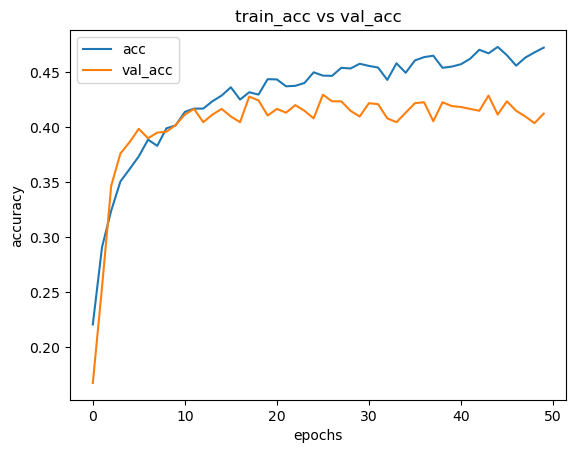

In [9]:
plt.plot(history.history['accuracy'], label = "acc")
plt.plot(history.history['val_accuracy'], label = "val_acc")
plt.title("train_acc vs val_acc")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend() 


**Fine-Tune Model Again**

Unfreeze the base model and train the entire model end-to-end with a low learning rate.
A very low learning rate helps to ensure that updates are small and gradual, preventing drastic changes to the model's learned features.

In [12]:
base_model.trainable = True
model.summary(show_trainable=True)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Low learning rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

epochs = 1
print("Fitting the end-to-end model")
history = model.fit(train_images, train_labels, epochs=5, validation_split = 0.2)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer (InputLayer)    │ (None, 224, 224, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_conv1 (Conv2D)       │ (None, 224, 224, 64)  │      1,792 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_conv2 (Conv2D)       │ (None, 224, 224, 64)  │     36,928 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_pool (MaxPooling2D)  │ (None, 112, 112, 64)  │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_conv1 (Conv2D)       │ (None, 112, 112, 128) │     73,856 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_conv2 (Conv2D)       │ (None, 112, 112, 128) │    147,584 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_pool (MaxPooling2D)  │ (None, 56, 56, 128)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv1 (Conv2D)       │ (None, 56, 56, 256)   │    295,168 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv2 (Conv2D)       │ (None, 56, 56, 256)   │    590,080 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv3 (Conv2D)       │ (None, 56, 56, 256)   │    590,080 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_pool (MaxPooling2D)  │ (None, 28, 28, 256)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv1 (Conv2D)       │ (None, 28, 28, 512)   │  1,180,160 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv2 (Conv2D)       │ (None, 28, 28, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv3 (Conv2D)       │ (None, 28, 28, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_pool (MaxPooling2D)  │ (None, 14, 14, 512)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv1 (Conv2D)       │ (None, 14, 14, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv2 (Conv2D)       │ (None, 14, 14, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv3 (Conv2D)       │ (None, 14, 14, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_pool (MaxPooling2D)  │ (None, 7, 7, 512)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 512)           │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ batch_normalization         │ (None, 512)           │      2,048 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 512)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 16)            │      8,208 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_1 (Dropout)         │ (None, 16)            │          0 │   - 

 Total params: 44,173,143 (168.51 MB)

 Trainable params: 14,724,039 (56.17 MB)

 Non-trainable params: 1,024 (4.00 KB)

 Optimizer params: 29,448,080 (112.34 MB)

Fitting the end-to-end model
Epoch 1/5
145/145 ━━━━━━━━━━━━━━━━━━━━ 1290s 9s/step - accuracy: 0.4365 - loss: 1.4429 - val_accuracy: 0.3986 - val_loss: 1.5533
Epoch 2/5
145/145 ━━━━━━━━━━━━━━━━━━━━ 1359s 9s/step - accuracy: 0.5063 - loss: 1.2999 - val_accuracy: 0.4064 - val_loss: 1.6445
Epoch 3/5
145/145 ━━━━━━━━━━━━━━━━━━━━ 1528s 11s/step - accuracy: 0.5277 - loss: 1.2279 - val_accuracy: 0.4435 - val_loss: 1.5300
Epoch 4/5
145/145 ━━━━━━━━━━━━━━━━━━━━ 1328s 9s/step - accuracy: 0.5544 - loss: 1.1478 - val_accuracy: 0.4806 - val_loss: 1.4862
Epoch 5/5
145/145 ━━━━━━━━━━━━━━━━━━━━ 1180s 8s/step - accuracy: 0.5805 - loss: 1.0837 - val_accuracy: 0.4314 - val_loss: 1.6095


**Test Model**

In [13]:
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability


21/21 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step


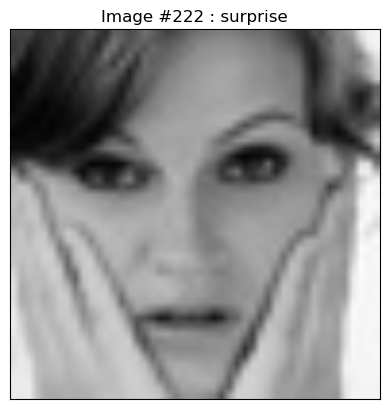

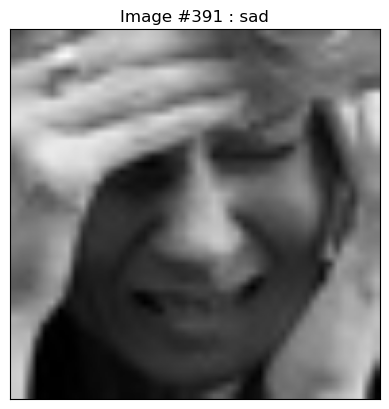

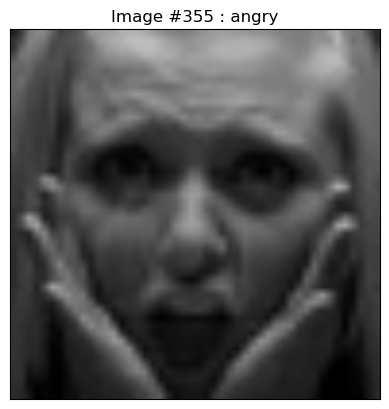

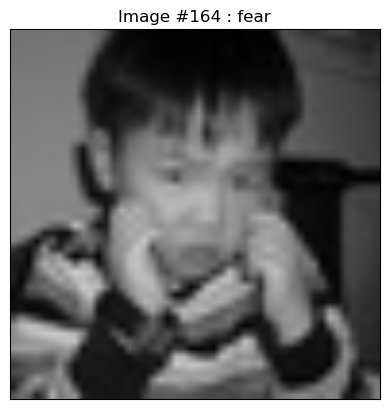

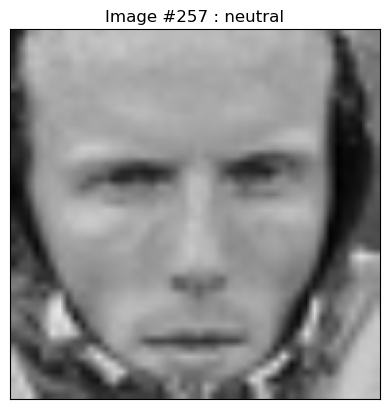

In [14]:
for i in range(5):
    display_random_image(class_names, test_images, pred_labels)
